In [6]:
# ==============================================================================
# CELLA 1: SETUP, INSTALLAZIONI e CONFIGURAZIONE
# ==============================================================================
import sys
import subprocess
import os
import yaml
import torch
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import CIFAR10
from sentence_transformers import SentenceTransformer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# --- Gestione Google Drive (per salvataggio persistente modello) ---
IN_COLAB = 'google.colab' in sys.modules
DRIVE_MOUNT_POINT = '/content/drive'
if IN_COLAB:
    print("🚀 Ambiente Colab rilevato. Tentativo di montaggio Google Drive...")
    from google.colab import drive
    try:
        drive.mount(DRIVE_MOUNT_POINT, force_remount=True)
        # Definisci un percorso base su Drive per i salvataggi
        DRIVE_SAVE_DIR = Path(DRIVE_MOUNT_POINT) / 'MyDrive' / 'VQA_Lite'
        DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
        print(f"✅ Google Drive montato. Path di salvataggio: {DRIVE_SAVE_DIR}")
    except Exception as e:
        print(f"⚠️ Errore montaggio Google Drive: {e}. Il modello non sarà salvato persistentemente.")
        DRIVE_SAVE_DIR = Path('.') # Fallback a directory locale
else:
    print("🔧 Ambiente non Colab. Il modello sarà salvato localmente.")
    DRIVE_SAVE_DIR = Path('.') # Salva nella directory corrente

# --- Installazione Librerie Centralizzata ---
# Installa *tutte* le librerie necessarie qui per pulizia
required_pkgs = [
    'sentence-transformers',
    'tqdm',
    'PyYAML',
    'grad-cam',
    'opencv-python-headless',
    'matplotlib'
]

if IN_COLAB or '--force-install' in sys.argv: # Permette reinstallazione locale
    print(f"\n⚙️ Installazione/Verifica librerie: {', '.join(required_pkgs)}...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q'] + required_pkgs)
    print("✅ Installazione completata.")

# --- Verifica Versioni ---
print('\n--- Informazioni Ambiente ---')
print('Python:', sys.version.split()[0])
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

# --- Configurazione Globale (cfg) ---
CIFAR10_CLASSES = ["aeroplano", "automobile", "uccello", "gatto", "cervo", "cane", "rana", "cavallo", "nave", "camion"]
cfg = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'model': {
        'question_dim': 384, # Dimensione embedding di all-MiniLM-L6-v2
        'image_feature_dim': 256,
        'attention_hidden_dim': 128,
        'dropout': 0.3,
    },
    'answers': CIFAR10_CLASSES,
    'categories': {'animale':[2,3,4,5,6,7],'veicolo':[0,1,8,9]},
    'training': {
        'batch_size': 256,
        'epochs': 10,
        'learning_rate': 5e-3,
        'weight_decay': 1e-4,
        'val_split': 0.1,
        'seed': 42,
        'num_workers': 2 if IN_COLAB else 4, # Ridotto per Colab free tier
    },
    'paths': {
        # Path aggiornato per salvare su Google Drive (o localmente se non in Colab)
        'model_save_path': str(DRIVE_SAVE_DIR / 'vqa_model_best.pth'),
        'data_dir': 'data', # Directory locale per dataset
        'train_npz': 'data/train_dataset_full.npz',
        'test_npz': 'data/test_dataset_full.npz'
    },
    'embedding_model': 'all-MiniLM-L6-v2'
}

DEVICE = cfg['device']
DATA_DIR = cfg['paths']['data_dir']
Path(DATA_DIR).mkdir(exist_ok=True) # Assicura che la dir dati esista

print(f"Dispositivo selezionato: {DEVICE}")
print(f"Path salvataggio modello: {cfg['paths']['model_save_path']}")

🚀 Ambiente Colab rilevato. Tentativo di montaggio Google Drive...
Mounted at /content/drive
✅ Google Drive montato. Path di salvataggio: /content/drive/MyDrive/VQA_Lite

⚙️ Installazione/Verifica librerie: sentence-transformers, tqdm, PyYAML, grad-cam, opencv-python-headless, matplotlib...
✅ Installazione completata.

--- Informazioni Ambiente ---
Python: 3.12.12
Torch: 2.8.0+cu126
CUDA available: True
Dispositivo selezionato: cuda
Path salvataggio modello: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth


In [7]:
# ==============================================================================
# CELLA 2: UTILITÀ e TRASFORMAZIONI IMMAGINE (CORRETTO)
# ==============================================================================
# (Import già fatti in Cella 1)

def set_seed(seed: int) -> None:
    """Imposta il seed per la riproducibilità."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_image_transform(is_training: bool = False) -> transforms.Compose:
    """
    Restituisce le trasformazioni per le immagini.
    - Include Resize a (32, 32) per inferenza/valutazione.
    - Include Augmentation per il training.
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if is_training:
        # Augmentations per il training (standard per CIFAR-10)
        return transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        # Pre-processing per Validazione / Test / **Inferenza**
        # === CORREZIONE FONDAMENTALE ===
        # Forziamo *qualsiasi* immagine alla dimensione 32x32 attesa dal modello
        return transforms.Compose([
            transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC), # Qualità resize
            transforms.ToTensor(),
            normalize,
        ])

set_seed(cfg['training']['seed'])
print("✅ Funzione 'get_image_transform' aggiornata per gestire immagini esterne.")

✅ Funzione 'get_image_transform' aggiornata per gestire immagini esterne.


In [8]:
# ==============================================================================
# CELLA 3: DEFINIZIONE MODELLO VQANet
# ==============================================================================
# (Codice invariato rispetto al tuo originale)

class VQANet(nn.Module):
    """Modello VQA basato su ResNet18 (Image Encoder) e Attention (Fusion)."""
    def __init__(self, num_answers, question_dim, image_feature_dim, attention_hidden_dim, dropout: float = 0.3):
        super().__init__()

        # Image Encoder: ResNet18 pre-addestrato
        backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2]) # Rimuove AvgPool e FC finale

        # Proiezione feature immagine
        self.proj = nn.Conv2d(512, image_feature_dim, kernel_size=1)

        # Meccanismo di Attenzione
        self.attention_conv = nn.Conv2d(image_feature_dim + question_dim, attention_hidden_dim, 1)
        self.attention_fc = nn.Conv2d(attention_hidden_dim, 1, 1)

        # Classificatore finale
        self.fc = nn.Sequential(
            nn.Linear(image_feature_dim + question_dim, attention_hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(attention_hidden_dim, num_answers)
        )

    def forward(self, image, question_emb, temperature: float = 1.0):
        # 1. Image Encoding
        x = self.backbone(image)
        img_features = self.proj(x)
        B, C, H, W = img_features.shape # Dimensione attesa: (B, C, 1, 1) dopo ResNet su 32x32

        # 2. Fusion e Attenzione
        question_emb_expanded = question_emb.unsqueeze(-1).unsqueeze(-1).expand(B, -1, H, W)
        combined_features = torch.cat([img_features, question_emb_expanded], dim=1)

        attn_hidden = torch.tanh(self.attention_conv(combined_features))
        logits = self.attention_fc(attn_hidden).view(B, -1) # Flatten spaziale implicito
        logits = logits / max(temperature, 1e-6)
        attn_weights = F.softmax(logits, dim=1).view(B, 1, H, W)

        # 3. Applicazione Attenzione
        attended_img_vector = (attn_weights * img_features).sum(dim=[2, 3])

        # 4. Classificazione Finale
        final_combined = torch.cat([attended_img_vector, question_emb], dim=1)
        return self.fc(final_combined)

In [9]:
# ==============================================================================
# CELLA 4: PREPARAZIONE DATASET (Generazione NPZ - CON SKIP)
# ==============================================================================
# (Import e definizioni iniziali invariate)

ANSWER_VOCAB = cfg['answers']
answer_to_idx = {a:i for i,a in enumerate(ANSWER_VOCAB)}

def create_indexed_dataset_full(dataset, description):
    # ... (definizione funzione create_indexed_dataset_full invariata) ...
    indices = []
    questions = []
    targets = []
    for idx, (_, label) in enumerate(tqdm(dataset, desc=f"Preparazione {description}", ncols=100)):
        true_class_name = ANSWER_VOCAB[label]
        # Tipo 1: Domanda Sì/No
        indices.append(idx)
        questions.append(f"C'è un {true_class_name}?")
        targets.append(label)
        # Tipo 2: Domanda Aperta
        indices.append(idx)
        questions.append("Che oggetto c'è?")
        targets.append(label)
    return indices, questions, targets

# --- Verifica Esistenza NPZ ---
TRAIN_NPZ_PATH = cfg['paths']['train_npz']
TEST_NPZ_PATH = cfg['paths']['test_npz']

# Carica sempre i dataset CIFAR grezzi e il modello embedding
# perché servono anche se gli NPZ esistono (per la classe Dataset e inferenza)
print("🔄 Caricamento CIFAR-10...")
train_set_cifar = CIFAR10(root=DATA_DIR, train=True, download=True)
test_set_cifar = CIFAR10(root=DATA_DIR, train=False, download=True)

# Carica modello embedding solo se non già caricato
if 'embedding_model' not in globals() or embedding_model is None:
    print("🔄 Caricamento SentenceTransformer...")
    try:
        embedding_model = SentenceTransformer(cfg['embedding_model'], device='cpu')
    except Exception as e:
        print(f"🔴 Errore caricamento embedding_model: {e}")
        embedding_model = None # Flag per indicare fallimento


# === NUOVA LOGICA DI SKIP ===
if Path(TRAIN_NPZ_PATH).exists() and Path(TEST_NPZ_PATH).exists():
    print(f"✅ File NPZ trovati in '{DATA_DIR}'. Salto la rigenerazione.")
else:
    print("⚠️ File NPZ non trovati. Rigenerazione in corso...")
    if embedding_model is None:
        print("🔴 Impossibile generare NPZ: modello embedding non caricato.")
    else:
        # Genera indici e domande
        train_indices, train_questions, train_targets = create_indexed_dataset_full(train_set_cifar, "Train FULL")
        test_indices, test_questions, test_targets = create_indexed_dataset_full(test_set_cifar, "Test FULL")

        # Calcola embedding
        print("🔄 Calcolo embedding domande (Train)...")
        train_emb = embedding_model.encode(train_questions, convert_to_numpy=True, show_progress_bar=True, batch_size=256, normalize_embeddings=False)
        print("🔄 Calcolo embedding domande (Test)...")
        test_emb = embedding_model.encode(test_questions, convert_to_numpy=True, show_progress_bar=True, batch_size=256, normalize_embeddings=False)

        # Conversione tipi + Salvataggio NPZ
        train_emb = train_emb.astype(np.float16)
        test_emb = test_emb.astype(np.float16)
        train_indices = np.asarray(train_indices, dtype=np.int32)
        test_indices = np.asarray(test_indices, dtype=np.int32)
        train_targets = np.asarray(train_targets, dtype=np.int16)
        test_targets = np.asarray(test_targets, dtype=np.int16)

        print("💾 Salvataggio NPZ compressi...")
        np.savez_compressed(TRAIN_NPZ_PATH, indices=train_indices, emb=train_emb, y=train_targets)
        np.savez_compressed(TEST_NPZ_PATH, indices=test_indices, emb=test_emb, y=test_targets)
        print(f"✅ Dataset salvati in {TRAIN_NPZ_PATH} e {TEST_NPZ_PATH}")

# Verifica finale caricamento embedding model
if 'embedding_model' not in globals() or embedding_model is None:
     print("🔴 ATTENZIONE: Il modello embedding non è stato caricato correttamente.")

🔄 Caricamento CIFAR-10...


100%|██████████| 170M/170M [00:19<00:00, 8.70MB/s]


🔄 Caricamento SentenceTransformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ File NPZ trovati in 'data'. Salto la rigenerazione.


In [10]:
# ==============================================================================
# CELLA 5: CLASSE DATASET e DATALOADER (Aggiornato)
# ==============================================================================

class VQADatasetNPZ(Dataset):
    """Dataset da NPZ e CIFAR-10, usa transform corretto."""
    def __init__(self, npz_path: str, cifar_dataset: CIFAR10, is_training: bool):
        data = np.load(npz_path)
        self.indices = data['indices']
        self.emb = data['emb']  # float16
        self.y = data['y']
        self.cifar = cifar_dataset
        # === Usa la transform corretta (con/senza augmentation) ===
        self.transform = get_image_transform(is_training=is_training)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        img_idx = int(self.indices[i])
        img, _ = self.cifar[img_idx] # Carica PIL Image
        image = self.transform(img).float() # Applica transform (ToTensor, Resize se non training, Normalize)
        q = torch.from_numpy(self.emb[i].astype(np.float32)) # float16 -> float32
        y = int(self.y[i])
        return image, q, y

# --- Creazione Dataset e DataLoader ---
# Assicurarsi che train_set_cifar e test_set_cifar siano caricati dalla cella precedente
try:
    # Passa 'is_training' flag al costruttore del Dataset
    train_ds_full = VQADatasetNPZ(cfg['paths']['train_npz'], cifar_dataset=train_set_cifar, is_training=True)
    test_ds = VQADatasetNPZ(cfg['paths']['test_npz'], cifar_dataset=test_set_cifar, is_training=False)
except NameError:
     print("🔴 Errore: 'train_set_cifar' o 'test_set_cifar' non definiti. Eseguire Cella 4.")
     # Blocco per evitare crash se la cella 4 non è stata eseguita correttamente
     train_ds_full, test_ds = None, None

if train_ds_full:
    # Split Train/Validation
    val_split = cfg['training']['val_split']
    val_size = max(1, int(len(train_ds_full) * val_split))
    train_size = len(train_ds_full) - val_size
    train_ds, val_ds = random_split(train_ds_full, [train_size, val_size])

    # Modifica: Dato che train_ds e val_ds sono Subset, dobbiamo accedere al dataset originale
    # per impostare correttamente la trasformazione per val_ds
    val_ds.dataset.transform = get_image_transform(is_training=False)
    # train_ds usa già la transform di train_ds_full (con augmentation)

    # DataLoaders
    BS = cfg['training']['batch_size']
    NW = cfg['training']['num_workers']
    PIN = DEVICE == 'cuda'

    train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)
    val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)
    test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW, pin_memory=PIN, persistent_workers=True if NW > 0 else False)

    print(f"Dataset: Train={train_size}, Val={val_size}, Test={len(test_ds)}")
    print(f"Dataloader: Batch Size={BS}, Num Workers={NW}")
else:
    print("🔴 DataLoaders non creati a causa di errore precedente.")

Dataset: Train=90000, Val=10000, Test=20000
Dataloader: Batch Size=256, Num Workers=2


In [11]:
# ==============================================================================
# CELLA 6: TRAINING e VALUTAZIONE (CON SKIP)
# ==============================================================================

# --- Funzione Evaluate (invariata) ---
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, q, y in tqdm(loader, desc="🔄 Valutazione", leave=False, ncols=100):
            images, q, y = images.to(device), q.to(device), y.to(device)
            out = model(images, q)
            pred = out.argmax(1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100.0 * correct / max(1, total)


# --- Inizializzazione Architettura Modello ---
# Definiamo sempre l'architettura, ci servirà per caricare i pesi o per il training
m_cfg = cfg['model']
num_answers = len(cfg['answers'])
model = VQANet(
    num_answers,
    m_cfg['question_dim'],
    m_cfg['image_feature_dim'],
    m_cfg['attention_hidden_dim'],
    dropout=m_cfg.get('dropout', 0.3)
).to(DEVICE)

model_save_path = cfg['paths']['model_save_path']
EPOCHS = cfg['training']['epochs']

# === NUOVA LOGICA DI SKIP TRAINING ===
if Path(model_save_path).exists():
    print(f"✅ Modello pre-addestrato trovato in: {model_save_path}")
    try:
        model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
        print("✅ Pesi caricati correttamente. Salto il training.")
        # Imposta best_acc a un valore fittizio alto se vuoi che Cell 7 valuti questo modello
        # Oppure recupera l'accuracy reale se l'hai salvata insieme al modello
        # Per ora, impostiamo best_acc=0.0; Cell 7 lo valuterà comunque.
        best_acc = 0.0 # O carica l'accuracy salvata se disponibile
    except Exception as e:
        print(f"🔴 Errore nel caricamento del modello pre-addestrato: {e}")
        print("   Procedo con il riaddestramento.")
        # Resetta best_acc per iniziare il training da capo
        best_acc = 0.0
        # Esegui blocco training (codice sotto)
        run_training = True
    else:
        # Se il caricamento ha successo, salta il training
        run_training = False
else:
    print(f"⚠️ Modello pre-addestrato non trovato in {model_save_path}. Inizio training...")
    best_acc = 0.0
    run_training = True

# --- Esegui Training (solo se run_training è True) ---
if run_training:
    if 'train_loader' not in globals() or 'val_loader' not in globals():
         print("🔴 Errore: Dataloaders non definiti. Eseguire Cella 5.")
    else:
        # Inizializza optimizer e criterion solo se si fa il training
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=cfg['training']['learning_rate'],
            weight_decay=cfg['training'].get('weight_decay', 0.0)
        )
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Opzionale

        print("\n--- Inizio Training Effettivo ---")
        for epoch in range(1, EPOCHS + 1):
            model.train()
            running_loss = 0.0
            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", ncols=100)

            for images, q, y in train_pbar:
                images, q, y = images.to(DEVICE), q.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                out = model(images, q)
                loss = criterion(out, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                running_loss += loss.item()
                train_pbar.set_postfix(loss=loss.item())

            val_acc = evaluate(model, val_loader, DEVICE)
            avg_loss = running_loss / len(train_loader)
            # scheduler.step() # Opzionale

            print(f"\n[Epoch {epoch}/{EPOCHS}] Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

            if val_acc > best_acc:
                best_acc = val_acc
                try:
                    torch.save(model.state_dict(), model_save_path)
                    print(f"💾 Modello salvato! Nuova best acc: {best_acc:.2f}% -> {model_save_path}")
                except Exception as e:
                    print(f"⚠️ Errore salvataggio modello: {e}")

        print(f"\n🏁 Training completato. Migliore Val Acc registrata: {best_acc:.2f}%")

# Alla fine di questa cella, la variabile 'model' conterrà
# o il modello caricato da file o il modello appena addestrato.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


✅ Modello pre-addestrato trovato in: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth
✅ Pesi caricati correttamente. Salto il training.


In [12]:
# ==============================================================================
# CELLA 7: VALUTAZIONE FINALE SU TEST SET
# ==============================================================================
# (Codice quasi invariato, usa path da config)

# Carica il modello migliore salvato (da Drive o locale)
model_save_path = cfg['paths']['model_save_path']
try:
    # Ricarica l'architettura per sicurezza (se il kernel è stato riavviato)
    m_cfg = cfg['model']
    num_answers = len(cfg['answers'])
    model = VQANet(
        num_answers, m_cfg['question_dim'], m_cfg['image_feature_dim'],
        m_cfg['attention_hidden_dim'], dropout=m_cfg.get('dropout', 0.3)
    ).to(DEVICE)

    model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
    print(f"✅ Modello migliore caricato da: {model_save_path}")

    # Valuta su Test Set
    if 'test_loader' in globals():
        test_acc = evaluate(model, test_loader, DEVICE)
        print(f"\n📊 Accuracy Finale sul Test Set: {test_acc:.2f}%")
    else:
        print("🔴 Errore: Test loader non definito. Eseguire Cella 5.")

except FileNotFoundError:
    print(f"🔴 ATTENZIONE: File modello non trovato in '{model_save_path}'.")
    print("   Eseguire il training (Cella 6) o verificare il path su Google Drive.")
except Exception as e:
     print(f"🔴 Errore caricamento modello: {e}")

✅ Modello migliore caricato da: /content/drive/MyDrive/VQA_Lite/vqa_model_best.pth



📊 Accuracy Finale sul Test Set: 86.11%



--- Test Inferenza su Immagine Specifica ---

Domanda 2: C'he oggetto c'è'?
Risposta 2: camion (Confidenza: 71.43%)


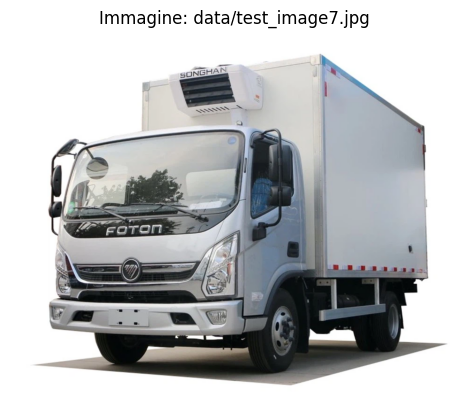

In [28]:
# ==============================================================================
# CELLA 8: LOGICA DI INFERENZA (Aggiornato per chiarezza)
# ==============================================================================
# (Import già fatti)

# --- Utility di Formattazione Risposta (Definita anche prima, per sicurezza) ---
ANSWERS_VOCAB = cfg['answers']
def format_answer(question: str, pred_idx: int) -> str:
    pred_class = ANSWERS_VOCAB[pred_idx]
    q = question.strip().lower()
    if q.startswith("c'è un ") or q.startswith("c'è una "):
        prefix_len = len("c'è un ") if q.startswith("c'è un ") else len("c'è una ")
        asked_class = q[prefix_len:-1].strip()
        return f"Sì, c'è un/una {pred_class}." if asked_class == pred_class else f"No, non c'è un/una {asked_class}. C'è un/una {pred_class}."
    if q.startswith("che "):
        return f"C'è un/una {pred_class}."
    return pred_class

# --- Funzione di Inferenza Principale ---
def run_vqa_inference(image_path: str, question: str, model: VQANet, device: str) -> (str, float):
    """Esegue VQA su un'immagine (locale) e domanda."""
    global embedding_model # Assicurati che sia caricato (da Cella 4)

    # 1. Carica e Trasforma Immagine (USA TRANSFORM DI INFERENZA)
    try:
        img = Image.open(image_path).convert('RGB')
        # Applica Resize(32,32), ToTensor, Normalize
        transform = get_image_transform(is_training=False)
        img_t = transform(img).unsqueeze(0).to(device).float()
    except FileNotFoundError:
        return f"ERRORE: Immagine non trovata: {image_path}", 0.0
    except Exception as e:
         return f"ERRORE caricamento/trasformazione immagine: {e}", 0.0

    # 2. Embedding Domanda
    if 'embedding_model' not in globals() or embedding_model is None:
        return "ERRORE: Modello embedding non caricato.", 0.0
    q_emb = embedding_model.encode(question, convert_to_tensor=True, normalize_embeddings=False)
    if q_emb.dim() == 1: q_emb = q_emb.unsqueeze(0)
    q_emb = q_emb.to(device).float()

    # 3. Inferenza VQA
    model.eval()
    with torch.no_grad():
        out = model(img_t, q_emb)
        probabilities = F.softmax(out, dim=1)
        pred_idx = out.argmax(1).item()
        confidence = probabilities[0, pred_idx].item() * 100.0

    formatted_answer = format_answer(question, pred_idx)
    return formatted_answer, confidence

# --- ESEMPIO DI INFERENZA CON IMMAGINE UTENTE ---
# 1. CARICA LA TUA IMMAGINE: Usa l'uploader file di Colab (pannello a sinistra)
#    e caricala nella directory 'data/' (es. 'data/my_cat.jpg')
# 2. IMPOSTA IL PERCORSO E LA DOMANDA QUI SOTTO:

# <---- MODIFICA QUESTI ---->
USER_IMAGE_PATH = 'data/test_image7.jpg' # Esempio: Cambia in 'data/mia_foto.jpg'
user_question_1 = "C'è un camion?"
user_question_2 = "C'he oggetto c'è'?"
# <------------------------->

print("\n--- Test Inferenza su Immagine Specifica ---")
if 'model' not in globals():
     print("🔴 Modello non caricato. Eseguire Cella 7.")
elif not Path(USER_IMAGE_PATH).exists():
     print(f"🔴 Immagine non trovata: {USER_IMAGE_PATH}")
     print("   Carica un'immagine nella directory 'data/' e aggiorna 'USER_IMAGE_PATH'.")
else:
    # Esegui per domanda 1
    ## answer1, conf1 = run_vqa_inference(USER_IMAGE_PATH, user_question_1, model, DEVICE)
    ## print(f"\nImmagine: {USER_IMAGE_PATH}")
    ## print(f"Domanda 1: {user_question_1}")
    ## print(f"Risposta 1: {answer1} (Confidenza: {conf1:.2f}%)")

    # Esegui per domanda 2
    answer2, conf2 = run_vqa_inference(USER_IMAGE_PATH, user_question_2, model, DEVICE)
    print(f"\nDomanda 2: {user_question_2}")
    print(f"Risposta 2: {answer2} (Confidenza: {conf2:.2f}%)")

    # Visualizza l'immagine caricata (opzionale)
    try:
        import matplotlib.pyplot as plt
        display_img = Image.open(USER_IMAGE_PATH)
        plt.imshow(display_img)
        plt.title(f"Immagine: {USER_IMAGE_PATH}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"(Impossibile visualizzare immagine: {e})")


⚙️ Generazione Vanilla Saliency Map per 'data/test_image7.jpg'...

--- Analisi Vanilla Saliency Map ---
Immagine: data/test_image7.jpg
Domanda: C'he oggetto c'è'?
Risposta Predetta: camion (Classe Target Saliency: camion)


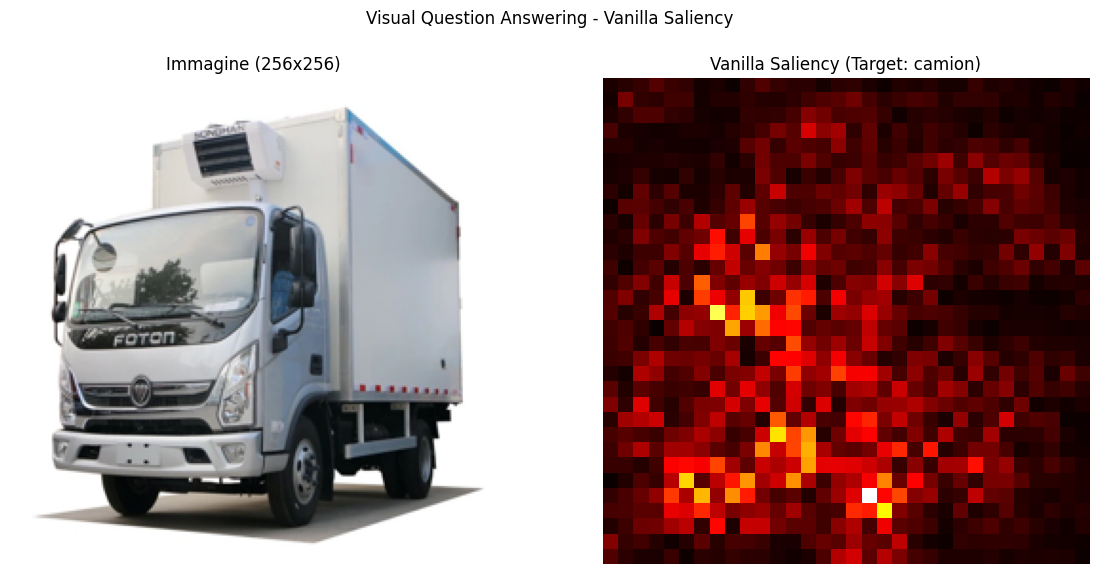

In [29]:
# ==============================================================================
# CELLA 9: VISUALIZZAZIONE ALTERNATIVA - VANILLA SALIENCY MAPS
# ==============================================================================

# --- Import necessari ---
# (La maggior parte sono già importati, ma li richiamiamo per chiarezza)
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Verifica se le librerie principali sono disponibili
try:
    import matplotlib.pyplot
    import numpy
except ImportError as e:
    print(f"🔴 Errore import librerie base (matplotlib/numpy): {e}")
    saliency_available = False
else:
    saliency_available = True

# --- Wrapper Modello (Necessario per fissare la domanda) ---
# Assicurati che VQAModelWrapper sia definito (Cella 9) o ridefiniscilo qui
# Se non è definito, ridefiniamolo:
if 'VQAModelWrapper' not in globals():
    print("⚠️ VQAModelWrapper non definito, lo ridefinisco...")
    class VQAModelWrapper(nn.Module):
        def __init__(self, model: VQANet, question_embedding: torch.Tensor):
            super().__init__()
            self.model = model
            self.q_emb = question_embedding.clone().detach().to(DEVICE)
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            B = x.size(0)
            q = self.q_emb.expand(B, -1)
            return self.model(x, q)

# --- Funzione per Calcolare Vanilla Saliency ---
def get_vanilla_saliency(model_wrapper, input_tensor, target_class_idx):
    """Calcola la mappa di salienza (gradienti input)."""
    # Clona il tensore per non modificare l'originale
    input_tensor_copy = input_tensor.clone().detach().requires_grad_(True)

    # Assicura che il modello sia in modalità valutazione
    model_wrapper.eval()
    model_wrapper.zero_grad()

    # Forward pass
    output = model_wrapper(input_tensor_copy)
    score = output[0, target_class_idx] # Score della classe target

    # Backward pass per calcolare i gradienti dell'output rispetto all'input
    score.backward()

    # Ottieni i gradienti dall'input_tensor_copy
    saliency = input_tensor_copy.grad.data.abs()

    # Riduci i gradienti prendendo il massimo valore assoluto lungo i canali
    saliency, _ = torch.max(saliency, dim=1)
    saliency = saliency.squeeze(0).cpu().numpy()

    # Normalizza la mappa tra 0 e 1 per la visualizzazione
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)
    return saliency

# --- Funzione per Eseguire e Visualizzare Saliency ---
def run_and_visualize_saliency(image_path: str, question: str, model: VQANet, device: str):
    """Carica immagine, esegue inferenza, calcola e mostra saliency map."""
    global embedding_model # Assicurati sia caricato

    # 1. Carica Immagine e Prepara Input Tensor (CON RESIZE 32x32)
    try:
        rgb_img = Image.open(image_path).convert('RGB')
        transform = get_image_transform(is_training=False)
        input_tensor = transform(rgb_img).unsqueeze(0).to(device)
    except FileNotFoundError:
        print(f"🔴 ERRORE: Immagine non trovata: {image_path}")
        return
    except Exception as e:
        print(f"🔴 ERRORE caricamento/trasformazione immagine: {e}")
        return

    # Immagine per visualizzazione (più grande)
    vis_img = np.array(rgb_img.resize((256, 256))) / 255.0

    # 2. Embedding Domanda
    if 'embedding_model' not in globals() or embedding_model is None:
         print("🔴 ERRORE: Modello embedding non caricato.")
         return
    q_emb = embedding_model.encode(question, convert_to_tensor=True, normalize_embeddings=False)
    if q_emb.dim() == 1: q_emb = q_emb.unsqueeze(0)
    q_emb = q_emb.to(device).float()

    # 3. Crea Wrapper
    wrapped_model = VQAModelWrapper(model, q_emb).to(device)

    # 4. Ottieni Predizione
    with torch.no_grad():
        output = wrapped_model(input_tensor)
        pred_idx = output.argmax(1).item()
        pred_class = ANSWERS_VOCAB[pred_idx]
        formatted_answer = format_answer(question, pred_idx)

    # 5. Calcola Saliency Map
    saliency_map = get_vanilla_saliency(wrapped_model, input_tensor, pred_idx)

    # 6. Visualizza
    print(f"\n--- Analisi Vanilla Saliency Map ---")
    print(f"Immagine: {image_path}")
    print(f"Domanda: {question}")
    print(f"Risposta Predetta: {formatted_answer} (Classe Target Saliency: {pred_class})")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(vis_img)
    plt.title("Immagine (256x256)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Usa una colormap 'hot' o 'viridis' per la mappa di calore
    plt.imshow(saliency_map, cmap='hot')
    plt.title(f"Vanilla Saliency (Target: {pred_class})")
    plt.axis('off')

    plt.suptitle(f"Visual Question Answering - Vanilla Saliency")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- Esecuzione Esempio Saliency ---
# Usa la stessa immagine e domanda definite nella cella 8 (USER_IMAGE_PATH, user_question_2)
if saliency_available:
    if 'model' in globals() and Path(USER_IMAGE_PATH).exists():
        print(f"\n⚙️ Generazione Vanilla Saliency Map per '{USER_IMAGE_PATH}'...")
        # Puoi scegliere quale domanda usare per l'analisi
        run_and_visualize_saliency(USER_IMAGE_PATH, user_question_2, model, DEVICE)
    else:
        print("🔴 Impossibile generare Saliency Map: Modello non caricato o immagine non trovata.")
else:
    print("⚠️ Librerie necessarie (matplotlib/numpy) non importate. Visualizzazione Saliency saltata.")